<a href="https://colab.research.google.com/github/pvt-16/Coursework/blob/main/Distributed_AI_Final_Project_RL_for_Lunar_Landing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Admin work

In [53]:
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip3 install box2d-py 
!pip3 install gym[Box_2D] #simulator 
!pip install gym pyvirtualdisplay > /dev/null 2>&1 #to create display
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1  #to make Display work
!pip3 install xvfbwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
import os
import glob
import torch
import base64
import random
import time
from collections import deque
from typing import List

import keras  
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

# This creates virtual display to send the frames for being rendered.
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

import warnings
warnings.filterwarnings("ignore")

### Setup

Name: Lunar Lander

State Components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

Actions:
1. Fire Main Engine
2. Fire Left Engine
3. Fire Right Engine
4. Do Nothing

Rewards:
*   Firing main engine: -0.3
*   Firing left/right engine: -0.03
*   Leg touch: +10
*   Good landing: +100
*   Crash: -100 


### RL Environment Setup (renderer)

In [55]:
display = Display(visible=0, size=(1366, 768))  #display object to show video of Lander
display.start()

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)   #create dir to store videos

In [56]:
#Load data video in colab - Video stored in Monitor Class
def show_video():
    mp4list = glob.glob(log_dir +'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 256px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("No video") # To handle exceptions

In [57]:
def wrap_env(env): 
    env = Monitor(env, log_dir, force=True)# './video', force=True)
    return env

### OpenAI Gym

In [58]:
env_ll = gym.make('LunarLander-v2') #
env_ll.seed(42)
testingEnv = wrap_env(env_ll)

In [59]:
def env_preview(env):
    env.reset()
    for dummy in range(100):
        env.render()
        state, reward, done, info = env.step(env.action_space.sample())
        if done:
            break
    env.close()

env_preview(testingEnv)
show_video()

In [60]:
env_ll.action_space    # Nop, fire left engine, main engine, right engine
#actions = {"none", "left", "main", "right"}

Discrete(4)

In [61]:
#gym.spaces.flatten_space(testingEnv.observation_space)

In [62]:
state_space = testingEnv.observation_space.shape 
action_space = testingEnv.action_space
print(action_space)    # Nop, fire left engine, main engine, right engine
print(state_space) # position in x axis and y axis(height); x,y velocities; lander angle and angular velocity; left and right left contact (bool)
print(testingEnv.reward_range)
print(testingEnv.spec.reward_threshold)
#actions = {"none", "left", "main", "right"}

Discrete(4)
(8,)
(-inf, inf)
200


In [63]:
# q_table = np.zeros((state_space[0], action_space.n))
# print(q_table)

### Hyper parameters

In [94]:
totalEpisodes = 50
maxStepsInEpisodes = 150   # to terminate the episode, else lander keeps hovering

learningRate = 0.01     #alpha
discountFactor = 0.95  #gamma

epsilon = 0.5    #exploration rate
minExplorationRate = 0.01
maxExplorationRate = 1
explorationDecay = 0.001   #reduce exploration over time as the agent learns more about the envi. => exploit info more
 
sampleExperiences = 50  #buffer memory
#maxExplorationRaterewards = [-0.3, -0.03, -0.03, 0, 10, 10, 100, -100] # fire main, left, right, nothing, touch - left, right, land, creash]

In [65]:
def testModel(model): 
  #testingEnv = wrap_env(gym.make("LunarLander-v2"))
  currentState = testingEnv.reset()
  finalReward = 0
  while (True):
    testingEnv.render()

    # action = model.policy(observation)  # User-defined policy function
    # observation, reward, done, info = testingEnv.step(action)
    action = testingEnv.action_space.sample()
    #action, states = model.predict(current_state, deterministic=True)
    observation, reward, done, info = testingEnv.step(action)
    #print(action)

    finalReward += reward
    if done:
      #observation, info = testingEnv.reset(return_info=True)
      #observation, info = 
      #testingEnv.reset()
      print(f'Final reward: {finalReward}')
      break
  testingEnv.close()
  show_video()

## Model Q-learning

#### State Discretization

In [66]:
# SOURCE FOR BUCKETIZING- https://github.com/omargup/Lunar-Lander/blob/master/Monte_Carlo_LunarLander.ipynb
def set_buckets_and_actions():
    env = testingEnv 
    number_of_buckets = (5,5,5,5,5,5,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n
    
    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))
    
    #New bound values for each dimension
    state_value_bounds[0] = [-1,1]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]
    
    return number_of_buckets, number_of_actions, state_value_bounds

numberOfBuckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = numberOfBuckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (numberOfBuckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (numberOfBuckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

#### Model

In [67]:
class QAgent():
  def __init__(self, name = "QAgent", epsilon = 0.5, epsilonDecay = False, logInterval = 10, learningRate = 0.01, discountFactor = 0.95) -> None:
    
    self.agentName = name
    self.actions = testingEnv.action_space
    self.actionLength = testingEnv.action_space.n

    self.alpha = learningRate
    self.discountFactor = discountFactor
    self.epsilon = epsilon
    self.epsilonDecay = epsilonDecay

    self.QTable =  np.zeros(numberOfBuckets + (self.actionLength,))

    self.trainEpisodes = []
    self.trainEpisodeSteps = []
    self.trainRewards = []
    self.currentAvg = 0
    self.movingAverage = []
    self.logInterval = logInterval

  def __getAction__(self, currentState):
    randExplorationVal = random.uniform(0, 1) 
    if (randExplorationVal < self.epsilon):
        # PLAY RANDOM ACTION
        selectedAction = testingEnv.action_space.sample() #random.random() 
    else:
        #PLAY BEST ACTION
        #rowIndexQ= 1 #based on current State
        stateQvalues = self.QTable[currentState]
        indices = [i for i, x in enumerate(stateQvalues) if x == max(stateQvalues)]
        # Calling random choice even if there is only 1 machine to sync the random state value with expected o/p
        selectedAction = random.choice(indices)    
    return selectedAction
  
  def storeEpisodeInfo(self):
    self.trainEpisodes.append(self.episodeCount)
    self.trainEpisodeSteps.append(self.episodeSteps)
    self.trainRewards.append(self.currentEpisodeRewards)
    self.currentAvg = np.mean(self.trainRewards)
    self.movingAverage.append(np.mean(self.currentAvg))

  def getTrainingInfo(self):
    return[self.trainEpisodes, self.trainEpisodeSteps, self.trainRewards, self.movingAverage]

  def __printEpisodeEnd__(self):
    print(f'Epi {self.episodeCount}: Steps={self.episodeSteps}, Final Reward = {self.currentEpisodeRewards}, Avg. = {self.currentAvg}')            
    
  def __updateQValues__(self, newState, actionTaken, reward, oldState):
    # Q(s,a)= (1 - α) Q(s,a) + α(R(s) + λ max(Q(s', a')))
    # QTable[x][y][c][action] = (1 - alpha) * QTable[x][y][c][action] + alpha * (R[x][y][c] + 0.95*maxSp)
    oldQValue = self.QTable[oldState][actionTaken]
    newStateBestQ = max(self.QTable[newState])
    newValue = (1 - self.alpha) * oldQValue+ self.alpha * (reward + discountFactor * newStateBestQ )
    self.QTable[oldState][actionTaken] = newValue

  def learn(self):
    self.episodeCount = 0 
    #print(totalEpisodes, maxStepsInEpisodes)
    while (self.episodeCount< totalEpisodes):        
        currentState = testingEnv.reset() # new episode - reset the envi. to starting state
        self.currentEpisodeRewards = 0
        self.episodeSteps = 0
        testingEnv.render()
        while self.episodeSteps< maxStepsInEpisodes:
            # Choose action
            currentState = bucketize(currentState)
            selectedAction = self.__getAction__(currentState)
            # perform action
            newState, reward, done, _ = testingEnv.step(selectedAction)

            #update knowledge
            self.__updateQValues__(newState=bucketize(newState), actionTaken=selectedAction, reward=reward, oldState=currentState)
            # current State is updated
            currentState = newState
            
            #Steps end
            self.currentEpisodeRewards += reward
            self.episodeSteps+=1 #episodeSteps + 1
            
            if done:
              break

        self.episodeCount+=1
        self.storeEpisodeInfo()
        
        if self.episodeCount % self.logInterval == 0:
          self.__printEpisodeEnd__()
        #print(f'Completed in {episodeCount} episodes')        
    return
  
  def predict(self, currentState, deterministic=True):
    return self.QTable[bucketize(currentState)]  

## Model Deep Q-Network (DQN)

### openAi DQN

In [68]:
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch = [64,64]) #dueling=False, 

#For evaluating the performance of the agent periodically and logging the results.
callback = EvalCallback(testingEnv, log_path = log_dir, deterministic=True) 

model_dqn = DQN("MlpPolicy", 
             testingEnv,
             policy_kwargs = policy_kwargs,
            
            learning_rate= 0.001,
            gamma = 0.99, #discount factor
            
            batch_size=1,  #batch update - not used
            buffer_size= 50, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps
            seed = 1, 
            verbose=0) 


### Our DQN implementation

In [69]:
class Experience():
    def __init__(self,  currentState, action, reward, newState, done) -> None:
      self.experience: tuple = (currentState, action, reward, newState, done)
      return

In [102]:
class DQNAgent(QAgent):
    def __init__(self, name = "DQNAgent", epsilon= 0.5, numberOfExperiences = 1000, sampleExperiences = 50) -> None:
      super().__init__(self)

      self.agentName = name
      self.numStates = env_ll.observation_space.shape[0]
      self.nA = env_ll.action_space.n
      self.numberOfExperiences = numberOfExperiences
      self.experienceReplayMemory = deque(maxlen= numberOfExperiences)
      self.experienceReplayMemoryLength = 0
      self.sampleExperiences = sampleExperiences
      self.epsilon = epsilon

      self.totalEpisodes = totalEpisodes

      self.targetUpdate: int = 10
      self.optimizer = Adam(self.alpha)
      self.deepQnetwork = self.__createNetwork__()
      #self.targetModel = self.createNetwork()

      self.loss = []

    def __getBestAction__(self, currentState):  #get best action based on the network's estimation of Q values
      # Using Deep NN to estimate Value for (s,a)
      # returns q values for each action
      #print(currentState)
      estimatedQvaluesForAction = self.deepQnetwork.predict(currentState)
      #print(estimatedQvaluesForAction)
      actionsIndexList = [i for i, x in enumerate(estimatedQvaluesForAction[0]) if x == max(estimatedQvaluesForAction[0])] 
      #print(actionsIndexList)
      # if multiple, random choice
      selectedAction = random.choice(actionsIndexList) if len(actionsIndexList)> 1 else actionsIndexList[0]  
      return selectedAction

    def __getAction__(self, currentState):
      
      # Implementing epsilon greedy approach
      randExplorationVal = random.uniform(0, 1) 
      if (randExplorationVal < self.epsilon):
        return testingEnv.action_space.sample() # PLAY RANDOM ACTION
      else:
        return self.__getBestAction__(currentState) #PLAY BEST ACTION

    # we randomly sample from Replay memory
    def __getExperiences__(self):
        expSamples : List[Experience]= random.sample(self.experienceReplayMemory, self.sampleExperiences)
        return expSamples
    
    # create the repository of experiences
    def __saveExperience__(self, currentState, action, reward, newState, done):
        #Experience et = Tuple(currentState, action, reward, nextState)
        e = Experience(currentState, action, reward, newState, done)
        if (len(self.experienceReplayMemory) < self.numberOfExperiences):
            self.experienceReplayMemory.append(e)
        else:
            self.experienceReplayMemory[self.experienceReplayMemoryLength % self.numberOfExperiences] = e
        
        self.experienceReplayMemoryLength = self.experienceReplayMemoryLength + 1
        return
    
    def __createNetwork__(self):
      model = Sequential()
      inputShape = 8
      model.add(Dense(28, input_dim = inputShape, activation="relu", name="l1"))
      model.add(Dense(28, activation="relu", name="l2"))
      #model.add(Dense(24, activation="relu"))
      model.add(Dense(testingEnv.action_space.n, activation="linear"))  # output layer
      model.compile(loss='mse', optimizer=SGD(lr=learningRate)) #Loss function: Mean Squared Error
      return model
    
    def __useExperiences__(self): #replay
        if self.experienceReplayMemoryLength > self.sampleExperiences:
          expSamples:list[Experience] = self.__getExperiences__()
          self.__trainModel__(expSamples)

    def __trainModel__(self,expSamples):
        index = 0
        x = []; y=[]
        allNewStates = []
        allCStates = []
        for sample in expSamples:
            currentState, action, reward, newState, done = sample.experience
            allCStates.append(currentState)
            allNewStates.append(newState)

        states = np.squeeze(allCStates)
        nextStates = np.squeeze(allNewStates)
        st_predict = self.deepQnetwork.predict(states) 
        nst_predict = self.deepQnetwork.predict(nextStates)

        for sample in expSamples:
            currentStateT, action, reward, newStateT, done = sample.experience

            #currentStateT = np.reshape(currentState, [1, self.numStates])
            #st_predict = self.deepQnetwork.predict(currentStateT)
            #newStateT = np.reshape(newState, [1, self.numStates])
            #next state expected Q value
            #nst_predict = self.deepQnetwork.predict(newStateT)
            #currentStateT = 
            x.append(currentStateT)

            #Predict from state
            nst_action_predict_model = nst_predict[index] #0
            if done == True: # game terminates in next step
                target = reward
            else: 
                target = reward + discountFactor * np.amax(nst_action_predict_model)
            
            st_predict[index][action] = target
            y.append(st_predict[0]) #append Qvalues for current state using index
            index += 1
        # Compare q values of actions to est. q value
        # compare loss
        # minimize loss 
        # Use SGD to backprop loss and adjust weights
        #Reshape for fitting in NN
        x_reshape = np.array(x).reshape(self.sampleExperiences,self.numStates)
        y_reshape = np.array(y)
        modelFitSummary = self.deepQnetwork.fit(x_reshape, y_reshape, epochs=1, verbose=0)
        self.loss.append( modelFitSummary.history['loss'][0])
    
    def learn(self, log_interval: int = 50, callback=None):
        self.episodeCount = 0 
        self.logInterval = log_interval
        while (self.episodeCount< self.totalEpisodes):        
            currentState = testingEnv.reset() # currentState
            self.currentEpisodeRewards = 0
            self.episodeSteps = 0
            while self.episodeSteps< maxStepsInEpisodes:
                # Choose action
                currentStateT = np.reshape(currentState, [1, self.numStates])
                selectedAction = self.__getAction__(currentStateT)
                # perform action
                #testingEnv.render()
                newState, reward, done, _ = testingEnv.step(selectedAction)
                newStateT = np.reshape(newState, [1, self.numStates])
                # Replay Memory
                self.__saveExperience__(currentStateT, selectedAction, reward, newStateT, done)
                
                #update knowledge
                self.__useExperiences__()
                
                #Steps end
                self.currentEpisodeRewards = self.currentEpisodeRewards + reward
                self.episodeSteps = self.episodeSteps + 1
                
                #self.__printEpisodeEnd__()
                # current State is updated
                currentState = newState
                if done:
                  break
            
            self.storeEpisodeInfo()
            self.episodeCount= self.episodeCount+1
            self.__printEpisodeEnd__()
            if self.episodeCount % self.logInterval == 0:
              print(f"Completed in {self.episodeCount} trials")      
        return

    def predict(self, currentState, deterministic=True):
      return self.__getBestAction__()

In [104]:
model_m2 = DQNAgent()

In [ ]:
model_m2.learn()

Epi 1: Steps=79, Final Reward = -427.9734713091815, Avg. = -427.9734713091815
Epi 2: Steps=90, Final Reward = -391.90215439439095, Avg. = -409.93781285178625
Epi 3: Steps=95, Final Reward = -87.05935399528964, Avg. = -302.3116598996207
Epi 4: Steps=80, Final Reward = -135.21209868251282, Avg. = -260.53676959534374
Epi 5: Steps=150, Final Reward = -65.00692848072816, Avg. = -221.43080137242063
Epi 6: Steps=94, Final Reward = -280.90211079284825, Avg. = -231.34268627582523
Epi 7: Steps=58, Final Reward = -153.41981197361926, Avg. = -220.2108470897958
Epi 8: Steps=119, Final Reward = -482.28365514163755, Avg. = -252.96994809627603
Epi 9: Steps=96, Final Reward = -359.1823056201478, Avg. = -264.771321154484


## Evaluations

In [73]:
# doing DQN model separately
# testingEnv.reset()
# model_dqn.learn(total_timesteps= 100000, log_interval=20, callback = callback)
# testModel(model_dqn)
# testingEnv.close()

In [103]:
modelQAgent = QAgent()
modelDQNAgent = DQNAgent()
#modelDQN = model_dqn


In [95]:
models = [modelQAgent, modelDQNAgent] #1. Q-learning 2. DQN learning
timeTaken = []
for model in models:
  testingEnv.reset()
  testingEnv.seed(42)
  startTime = time.time()
  model.learn()
  endTime = time.time()
  testingEnv.close()
  timeTaken.append(endTime - startTime)

Epi 10: Steps=150, Final Reward = 43.085174650031995, Avg. = -94.94866469083243
Epi 20: Steps=128, Final Reward = -178.52969146401665, Avg. = -97.71968128992164
Epi 30: Steps=118, Final Reward = -94.15084785741276, Avg. = -105.44607606239204
Epi 40: Steps=150, Final Reward = 26.500536224656784, Avg. = -102.82975834114113
Epi 50: Steps=77, Final Reward = -110.44902397245511, Avg. = -107.69739753903906
Epi 1: Steps=130, Final Reward = -315.16571804102097, Avg. = -241.37007068444757
Epi 2: Steps=105, Final Reward = -255.67258519596805, Avg. = -244.2305735867517
Epi 3: Steps=150, Final Reward = -497.6396549227531, Avg. = -286.4654204760853


In [96]:
modelName = []; allTrainEpisodes=[]; alltrainEpisodeSteps=[];trainRewards=[]; movingAverage=[]
def createEvaluationDf(models): # create [model name,  (reward, mean, epi)] into dataframe
  for model in models:
    trainStats = model.getTrainingInfo()  #self.trainEpisodes, self.trainEpisodeSteps, self.trainRewards, self.movingAverage
    statLength = len(trainStats[0])
    modelName.append([model.agentName] * statLength)
    allTrainEpisodes.append(trainStats[0])
    alltrainEpisodeSteps.append(trainStats[1])
    trainRewards.append(trainStats[2])
    movingAverage.append(trainStats[3])
  evalResults = pd.DataFrame()
  evalResults['Model'] = np.array(modelName).flatten(order='C') #np.squeeze(modelName)
  evalResults['Episodes'] = np.array(allTrainEpisodes).flatten(order='C') #np.squeeze(allTrainEpisodes)
  evalResults['EpisodeSteps'] = np.array(alltrainEpisodeSteps).flatten(order='C') #np.squeeze(alltrainEpisodeSteps)
  evalResults['Rewards'] = np.array(trainRewards).flatten(order='C') #np.squeeze(trainRewards)
  evalResults['MovingAverage'] = np.array(movingAverage).flatten(order='C')  #np.squeeze(movingAverage)
  return evalResults

In [97]:
evalMetrics = createEvaluationDf(models)

In [98]:
evalMetrics

,Model,Episodes,EpisodeSteps,Rewards,MovingAverage
0,"[QAgent, QAgent, QAgent, QAgent, QAgent, QAgen...","[1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[100, 100, 100, 130, 140, 123, 106, 116, 150, ...","[-145.13025485083878, -105.68389467980316, 32....","[-145.13025485083878, -125.40707476532097, -72..."
1,"[DQNAgent, DQNAgent, DQNAgent, DQNAgent, DQNAg...","[0, 1, 2, 0, 1, 2]","[85, 100, 90, 130, 105, 150]","[-484.62754787809877, -106.37022977096994, -59...","[-484.62754787809877, -295.49888882453433, -21..."


#### graph: Training time vs Algo

In [79]:
# #x = np.linspace(0, , model.movingAverage)
# plt.bar(timeTaken, height=1)
# plt.legend()
# plt.show()

#### graph of Rewads vs Episodes  - grouped by algo 

In [80]:
#testModel(model_dqn)

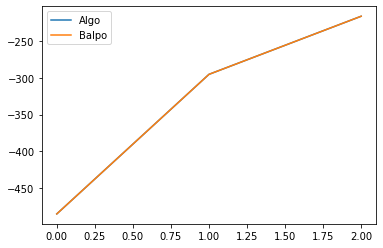

In [81]:
#x = np.linspace(0, , model.movingAverage)
x = [i for i in range(model.episodeCount)]
plt.plot(x, model.movingAverage, label='Algo')
plt.plot(x, model.movingAverage, label='Balpo')
plt.legend()
plt.show()

#### graph: Rewards vs episodes - grouped by learning rate

#### graph: Rewards vs episodes - grouped by epsilon

In [82]:
modelsDQN = [DQNAgent(name="epsilon=0.1", epsilon = 0.1), 
          DQNAgent(name="epsilon=0.05", epsilon = 0.05), 
          DQNAgent(name="epsilon=0.1", epsilon = 0.5)]

In [83]:
modelsQ = [QAgent(name="epsilon=0.1", epsilon = 0.1), 
          QAgent(name="epsilon=0.05", epsilon = 0.05), 
          QAgent(name="epsilon=0.1", epsilon = 0.5)]

In [84]:
timeTaken = []
for model in modelsQ:
  startTime = time.time()
  model.learn()
  endTime = time.time()
  testingEnv.close()
  timeTaken.append(endTime - startTime)
evalMetricsQ = createEvaluationDf(modelsQ)

In [85]:
timeTaken = []
for model in modelsDQN:
  startTime = time.time()
  model.learn()
  endTime = time.time()
  testingEnv.close()
  timeTaken.append(endTime - startTime)
evalMetricsDQN = createEvaluationDf(modelsDQN)

Epi 1: Steps=62, Final Reward = -234.99938645466227, Avg. = -234.99938645466227
Epi 2: Steps=100, Final Reward = -516.0191894576864, Avg. = -375.5092879561743
Epi 3: Steps=79, Final Reward = -500.2847875693917, Avg. = -417.1011211605801
Epi 1: Steps=80, Final Reward = -603.6290475876244, Avg. = -603.6290475876244
Epi 2: Steps=84, Final Reward = -110.94391389082077, Avg. = -357.2864807392226
Epi 3: Steps=80, Final Reward = -123.77659582868941, Avg. = -279.44985243571153
Epi 1: Steps=100, Final Reward = -77.71751757025314, Avg. = -77.71751757025314
Epi 2: Steps=92, Final Reward = -411.73763078934894, Avg. = -244.72757417980102
Epi 3: Steps=100, Final Reward = 17.819414826241683, Avg. = -157.2119111777868


In [86]:
evalMetricsByEpsilon = evalMetrics.groupby("Model")

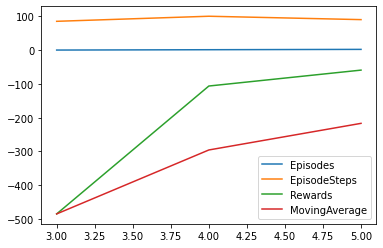

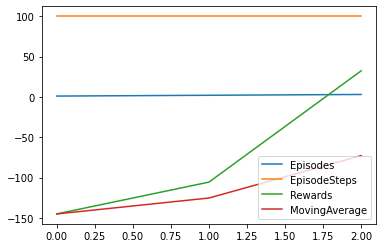

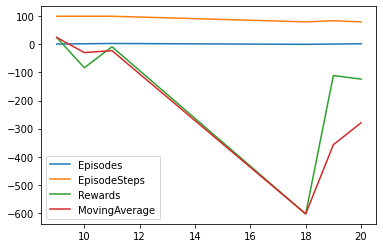

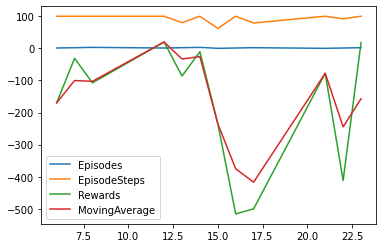

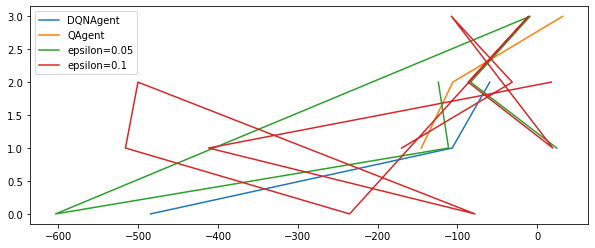

In [87]:
evalMetricsByEpsilon.plot()
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in evalMetricsByEpsilon:
    ax.plot(grp['Rewards'], grp['Episodes'], label=key)

ax.legend()
plt.show()

## Extra Resources  (please ignore)

In [88]:
          # losses = []
          # allActions = []
          # allRewards = []
          # allDones = []
          # for sample in expSamples:
          #     currentState, action, reward, newState, done = sample.experience
          #     allCStates.append(currentState)
          #     # allActions.append(action)
          #     # allRewards.append(reward)
          #     allNewStates.append(newState)
          #     # allDones.append(done)

          #states = np.squeeze(allCStates)
          #nextStates = np.squeeze(allNewStates)

#### graph: Memory vs Algo

In [89]:
  #inputs = keras.Input(shape=inputShape)
  # op_l1 = Dense(24, activation= 'relu')(inputs)
  # op_l2 = Dense(48, activation= 'relu')(op_l1)
  # op_l3 = Dense(24, activation= 'relu')(op_l2)
  # outputs = Dense(testingEnv.action_space.n, activation= 'relu')(op_l3)
  # model = keras.Model(inputs=inputs, outputs=outputs)
  #model.add(keras.layers.Input(shape=inputShape))

In [90]:
  # model = keras.Sequential() 
  # #   24: Number of neurons, input_dim: Number of input variables, activation: Rectified Linear Unit (relu) ranges >= 0
  # model.add(keras.layers.Dense(24, input_dim=self.numStates, activation='relu')) #[Input] -> Layer 1
  # model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
  # model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
  # model.compile(loss='mean_squared_error', 
  #               optimizer= Adam(learningRate)) 

In [91]:
  # inputShape = testingEnv.observation_space.shape[0]

        # inputs = keras.Input(shape=inputShape)
        # op_l1 = Dense(24, activation= 'relu')(inputs)
        # op_l2 = Dense(48, activation= 'relu')(op_l1)
        # op_l3 = Dense(24, activation= 'relu')(op_l2)
        # outputs = Dense(testingEnv.action_space.n, activation= 'relu')(op_l3)
        # model = keras.Model(inputs=inputs, outputs=outputs)
        # #model.add(keras.layers.Input(inputShape))
        # # model.add()   #layer 1
        # # model.add()
        # # model.add()
        # #model.add(Dense(testingEnv.action_space.n))
        # model.compile(optimizer= Adam(learning_rate=learningRate), loss= MeanSquaredError)
        

In [92]:
def neuralNetwork():
  model = Sequential()
  inputShape = 8
  model.add(Dense(28, input_dim = inputShape, activation="relu", name="l1"))
  model.add(Dense(28, activation="relu", name="l2"))
  #model.add(Dense(24, activation="relu"))
  model.add(Dense(testingEnv.action_space.n, activation="linear"))  # output layer
  model.compile(loss='mse', optimizer=Adam(lr=learningRate))
  return model

### Cartpole

In [93]:
#testModel(testingEnv)

https://www.reddit.com/r/reinforcementlearning/comments/tda0p0/openai_gym_lunar_lander_v2_question/

### using function approximation

https://www.reddit.com/r/reinforcementlearning/comments/hvg35k/solving_lunarlander_with_linear_function/


